In [31]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split

from glob import glob
from skimage.io import imread
from os import listdir
import seaborn as sns
sns.set()

import time
import copy
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
import cv2

In [30]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

## Load Dataset and Preprocess Data

In [2]:
base_path = "D:/university/concordia/Winter 22/Machine Learning/Project/breast cancer/dataset/"
folder = listdir(base_path)
len(folder)

279

In [3]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
total_images

277524

Storing the image_path, patient_id and the target

In [48]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,D:/university/concordia/Winter 22/Machine Lear...,0
1,10253,D:/university/concordia/Winter 22/Machine Lear...,0
2,10253,D:/university/concordia/Winter 22/Machine Lear...,0
3,10253,D:/university/concordia/Winter 22/Machine Lear...,0
4,10253,D:/university/concordia/Winter 22/Machine Lear...,0


In [59]:
non_cancer_data = data.query("target == 0").head(2000)
print(non_cancer_data['target'].value_counts())
cancer_data = data.query("target == 1").head(2000)
print(cancer_data['target'].value_counts())
sliced_data = pd.concat([non_cancer_data,cancer_data])
print(sliced_data['target'].value_counts())

0    2000
Name: target, dtype: int64
1    2000
Name: target, dtype: int64
1    2000
0    2000
Name: target, dtype: int64


In [60]:
print(sliced_data['target'].value_counts())

1    2000
0    2000
Name: target, dtype: int64


In [61]:
sliced_data.target.unique()

array([0, 1], dtype=object)

In [62]:
sliced_data.shape

(4000, 3)

In [63]:
sliced_data.head()
sliced_data.loc[:, "target"] = data.target.astype(np.str)
sliced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 9253
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  4000 non-null   object
 1   path        4000 non-null   object
 2   target      4000 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB


In [68]:
unique_paths = sliced_data.path.unique()

In [69]:
sub_train_ids, test_ids = train_test_split(unique_paths,
                                           test_size=0.2,
                                           random_state=0)
train_ids, valid_ids = train_test_split(sub_train_ids, test_size=0.1, random_state=0)

In [71]:
print(f"Now, we're taking {round(len(train_ids)/unique_paths.shape[0]*100, 1)}% for training, {round(len(valid_ids)/unique_paths.shape[0]*100,1)}% for validation, {round(len(test_ids)/unique_paths.shape[0]*100,1)}% for testing")

Now, we're taking 72.0% for training, 8.0% for validation, 20.0% for testing


In [72]:
print(f'{len(train_ids)}, {len(valid_ids)}, {len(test_ids)}')

2880, 320, 800


In [74]:
train_df = sliced_data.loc[sliced_data.path.isin(train_ids),:].copy()
test_df = sliced_data.loc[sliced_data.path.isin(test_ids),:].copy()
valid_df = sliced_data.loc[sliced_data.path.isin(valid_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (2880, 3)
test set shape: (800, 3)
validation set shape: (320, 3)


In [75]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [77]:
target_size = (224,224)
batch_size = 64

In [78]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 2880 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


### Target distributions 
Let's take a look at the target distribution difference of the datasets:

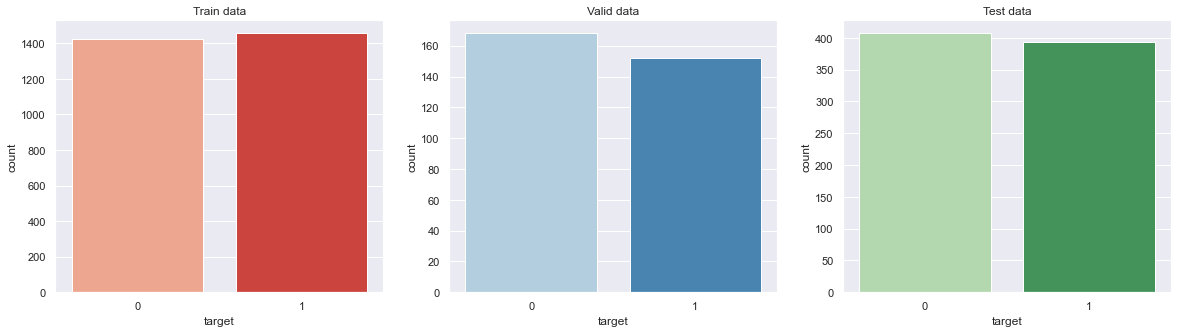

In [79]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

## VGG16

### Creating a custom model

Function for creating a VGG block.

In [80]:
def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [81]:
# define model input
visible = Input(shape=(224, 224, 3))

# add vgg module
layer = vgg_block(visible, 64, 2)
layer = vgg_block(layer, 128, 2)
layer = vgg_block(layer, 256, 3)
layer = vgg_block(layer, 512, 3)
layer = vgg_block(layer, 512, 3)

# add flatten
layer = keras.layers.Flatten()(layer)

# add Dense
layer = keras.layers.Dense(4096, activation='relu')(layer)
layer = keras.layers.Dense(4096, activation='relu')(layer)
layer = keras.layers.Dense(1, activation='sigmoid')(layer)

# create model
vgg_model = Model(inputs=visible, outputs=layer)
print(type(vgg_model))

# summarize model
vgg_model.summary()

<class 'keras.engine.functional.Functional'>
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
              

### Training

Loss and Optimizer

In [82]:
vgg_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= 0.001), metrics=['accuracy'])

Callbacks

In [83]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint("Breast_Cancer_VGG16_model.h5", save_best_only=True, verbose = 0)
callbacks = [
    early_stopping,
    model_checkpoints
]

History

In [ ]:
vgg_history = vgg_model.fit(train_batches, validation_data = valid_batches, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)